# CDC Weekly Mortality Data for 121 Cities 1962-2016

### Importing Data

The CDC dataset used here provides the total number of weekly deaths in 121 US cities from 1962-2016.  It also provides the age breakdown of weekly deaths, as well as deaths due to flu and pnumonia.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
df=pd.read_csv('https://data.cdc.gov/api/views/mr8w-325u/rows.csv?accessType=DOWNLOAD',index_col='Week Ending Date',parse_dates=True)

In [2]:
df.head()   

,Year,WEEK,REGION,State,City,Pneumonia and Influenza Deaths,All Deaths,<1 year (all cause deaths),1-24 years (all cause deaths),25-44 years,45-64 years (all cause deaths),65+ years (all cause deaths)
Week Ending Date,,,,,,,,,,,,
1962-01-06,1962,1,1,MA,Boston,11.0,262.0,10.0,8.0,11.0,87.0,146.0
1962-01-13,1962,2,1,MA,Boston,11.0,270.0,14.0,8.0,11.0,70.0,167.0
1962-01-20,1962,3,1,MA,Boston,5.0,237.0,11.0,8.0,10.0,66.0,142.0
1962-01-27,1962,4,1,MA,Boston,12.0,285.0,22.0,7.0,8.0,73.0,175.0
1962-02-03,1962,5,1,MA,Boston,5.0,245.0,15.0,9.0,17.0,62.0,142.0


We are only interested in the State, City and All Deaths Columns

In [3]:
df=df.drop(columns=['Year', 'WEEK', 'REGION',
       'Pneumonia and Influenza Deaths',
       '<1 year (all cause deaths)', '1-24 years (all cause deaths)',
       '25-44 years', '45-64 years (all cause deaths)',
       '65+ years (all cause deaths)'])

In [4]:
df.head()

,State,City,All Deaths
Week Ending Date,,,
1962-01-06,MA,Boston,262.0
1962-01-13,MA,Boston,270.0
1962-01-20,MA,Boston,237.0
1962-01-27,MA,Boston,285.0
1962-02-03,MA,Boston,245.0


In [5]:
df.tail()

,State,City,All Deaths
Week Ending Date,,,
2016-09-03,WA,Tacoma,136.0
2016-09-10,WA,Tacoma,136.0
2016-09-17,WA,Tacoma,129.0
2016-09-24,WA,Tacoma,143.0
2016-10-01,WA,Tacoma,136.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 346342 entries, 1962-01-06 to 2016-10-01
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State       340300 non-null  object 
 1   City        340300 non-null  object 
 2   All Deaths  344871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.6+ MB


### Dealing with Missing Values 

In [7]:
df.loc[(df['City'].isnull()==True) & df['State'].isnull()==True].shape

(6042, 3)

In [8]:
df.loc[(df['City'].isnull()==True)].shape

(6042, 3)

In [9]:
df.loc[df['State'].isnull()==True].shape

(6042, 3)

In [10]:
df.loc[df['All Deaths'].isnull()==True].City.unique()

array(['Boston', 'Hartford', 'Bridgeport', 'Allentown', 'Cambridge',
       'Fall River', 'Yonkers', 'South Bend', 'Youngstown', 'Des Moines',
       'Kansas City', 'Lincoln', 'Lynn', 'New Bedford', 'Providence',
       'Somerville', 'Springfield', 'Waterbury', 'Worcester', 'Buffalo',
       'Camden', 'Elizabeth', 'Jersey City', 'New York', 'Newark',
       'Paterson', 'Philadelphia', 'Reading', 'Schenectady', 'Scranton',
       'Syracuse', 'Trenton', 'Utica', nan, 'Chicago', 'Cincinnati',
       'Cleveland', 'Columbus', 'Detroit', 'Evansville', 'Fort Wayne',
       'Gary', 'Indianapolis', 'Milwaukee', 'Peoria', 'Rockford',
       'Toledo', 'Duluth', 'Minneapolis', 'Saint Louis', 'Saint Paul',
       'Atlanta', 'Wichita', 'Wilimington', 'Charlotte', 'Birmingham',
       'Baton Rouge', 'Corpus Christi', 'New Orleans', 'Jacksonville',
       'Miami', 'Norfolk', 'Richmond', 'Saint Petersburg', 'Washington',
       'Chattanooga', 'Knoxville', 'Lexington', 'Memphis', 'Mobile',
       'Montg

In [11]:
len(df.loc[df['All Deaths'].isnull()==True].City.unique())

102

102 Cities have missing values for All Deaths.  We should investigate how these missing values are distributed, but it is safe delete the entries with missing state and city values.

In [12]:
df=df.dropna(subset=['State','City'],axis=0)

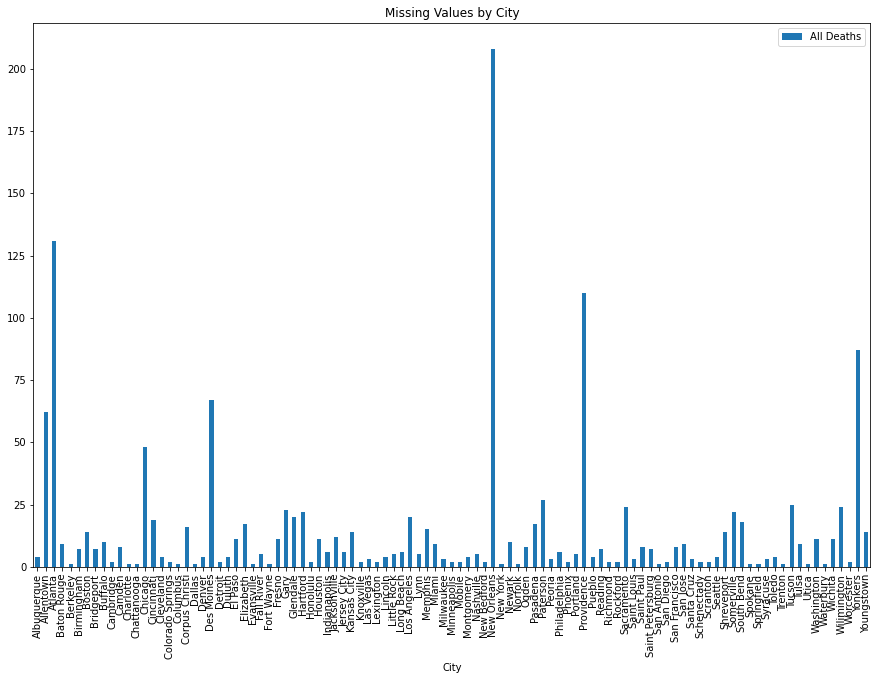

In [13]:
df.loc[df['All Deaths'].isnull()==True].fillna(1).groupby('City').sum().plot(kind='bar')
plt.title('Missing Values by City')
plt.show()

It is clear that some cities have a large number of missing values in their respective datasets.

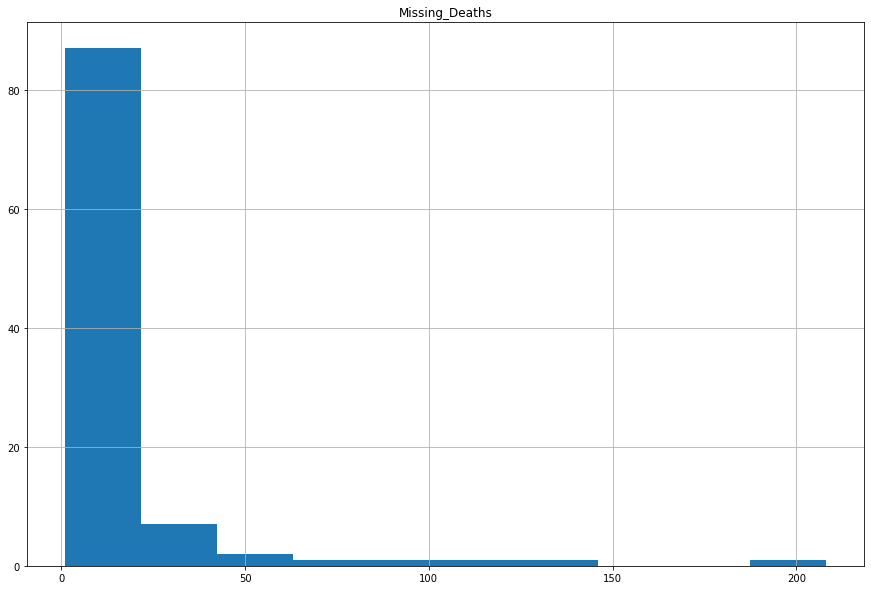

In [14]:
missing=pd.DataFrame(df.loc[df['All Deaths'].isnull()==True].fillna(1).groupby('City').sum())
missing.columns=['Missing_Deaths']
missing.hist()
plt.show()

The vast majority of cities have fewer than 50 missing values.  I will drop the outlier cities that are more than three standard deviations from the mean.  

In [15]:
s=missing.Missing_Deaths.std()
x_bar=missing.Missing_Deaths.mean()
upper,lower = x_bar + 3*s, x_bar - 3*s
missing=missing[(missing['Missing_Deaths']<upper)&(missing['Missing_Deaths']>lower)]

In [16]:
cities_final=missing.index

In [17]:
df=pd.DataFrame(df.loc[df['City'].isin(cities_final)])

In [18]:
df.isnull().sum()

State           0
City            0
All Deaths    962
dtype: int64

In [19]:
df.City.unique()

array(['Boston', 'Hartford', 'Bridgeport', 'Cambridge', 'Somerville',
       'Allentown', 'Fall River', 'Camden', 'Yonkers', 'Gary',
       'South Bend', 'Youngstown', 'Des Moines', 'Kansas City', 'Lincoln',
       'Lynn', 'New Bedford', 'Springfield', 'Waterbury', 'Worcester',
       'Buffalo', 'Elizabeth', 'Jersey City', 'New York', 'Newark',
       'Paterson', 'Philadelphia', 'Reading', 'Schenectady', 'Scranton',
       'Syracuse', 'Trenton', 'Utica', 'Chicago', 'Cincinnati',
       'Cleveland', 'Columbus', 'Detroit', 'Evansville', 'Fort Wayne',
       'Indianapolis', 'Milwaukee', 'Peoria', 'Rockford', 'Toledo',
       'Duluth', 'Minneapolis', 'Saint Louis', 'Saint Paul', 'Wichita',
       'Wilimington', 'Charlotte', 'Jacksonville', 'Birmingham',
       'Baton Rouge', 'Corpus Christi', 'Miami', 'Norfolk', 'Richmond',
       'Saint Petersburg', 'Washington', 'Chattanooga', 'Knoxville',
       'Lexington', 'Memphis', 'Mobile', 'Montgomery', 'Nashville',
       'Dallas', 'El Paso', 'Ho

We will fill each missing value left over with the average number of deaths with respect to each city

In [20]:
city_list=list(df.City.unique())
df_list=[]
for i in range(len(city_list)):
    x=pd.DataFrame(df[df.City==city_list[i]]).fillna(df[df.City==city_list[i]]['All Deaths'].mean())
    x=x.loc[:'2015',:].dropna()
    df_list.append(x)
df=pd.concat(df_list)

There is also a chance that values of zero were present instead of NaN.  

In [21]:
df[df['All Deaths']==0]['City'].value_counts()

Des Moines      92
Somerville      10
Jacksonville     7
Baton Rouge      4
Shreveport       4
Paterson         3
Tulsa            2
Lynn             2
Seattle          2
Saint Louis      2
Gary             1
Philadelphia     1
Berkeley         1
San Antonio      1
Indianapolis     1
Trenton          1
Duluth           1
Wilimington      1
Washington       1
Little Rock      1
San Jose         1
Name: City, dtype: int64

In [22]:
df[(df['All Deaths']==0) & (df['City']== 'Des Moines')].loc['2015'].resample('A').sum()

,All Deaths
Week Ending Date,
2015-12-31,0.0


It can be shown that the entire year was recorded as zero for Des Moines.  Rather than have one city with a different year count than the others, We will eliminate Des Moines from our dataset for convenience.

In [23]:
df=pd.DataFrame(df[df['City'] != 'Des Moines'])
city_list=list(df.City.unique())
df_list=[]
for i in range(len(city_list)):
    x=pd.DataFrame(df[df.City==city_list[i]])
    df_list.append(x)
df=pd.concat(df_list)

Note: the year 2016 was deleted because the year was incomplete for all cities

## Feature Engineering 

We are concerned with finding the proportion of monthly deaths relative to the yearly total in each city.  We will use this to forcast the expected proportion of yearly deaths to occur between 02/01/2020 and 08/01/2020.  The data represents each city as a time series from 1962-2015

In [24]:
city_list=list(df.City.unique())
df_list_two=[]
for i in range(len(city_list)):
    x=df_list[i]
    xmonth=pd.DataFrame(x['All Deaths'].resample('M').sum())
    xmonth['index']=xmonth.index
    xyear=pd.DataFrame(x['All Deaths'].resample('A').sum())
    xyear['index']=xyear.index
    x=pd.merge(xmonth,xyear,on='index',how='outer').fillna(method='bfill')
    x=x.set_index(pd.DatetimeIndex(x['index'])).drop(columns='index').dropna()
    x.columns=['month_death','year_death']
    x['month/year']=x['month_death']/x['year_death']
    df_list_two.append(x)

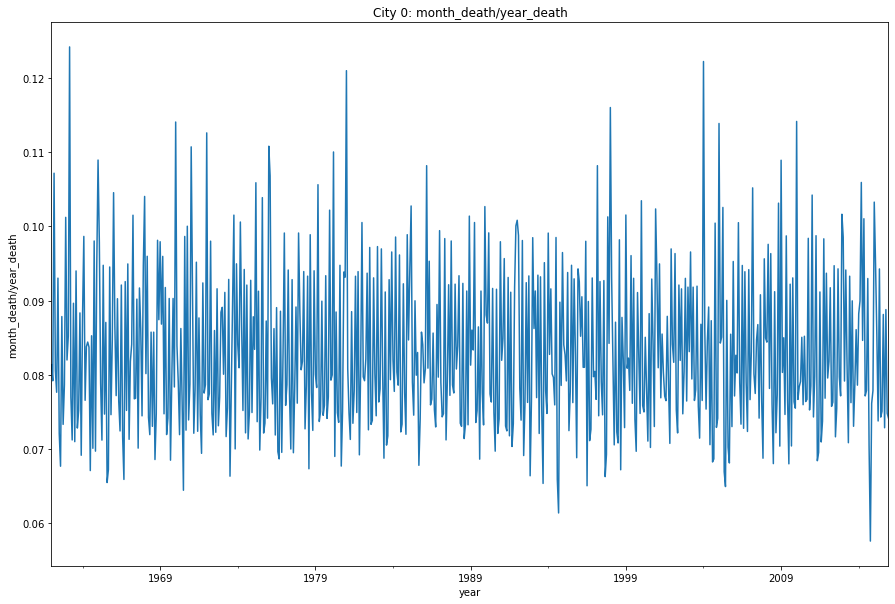

In [25]:
df_list_two[0]['month/year'].plot()
plt.title('City 0: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

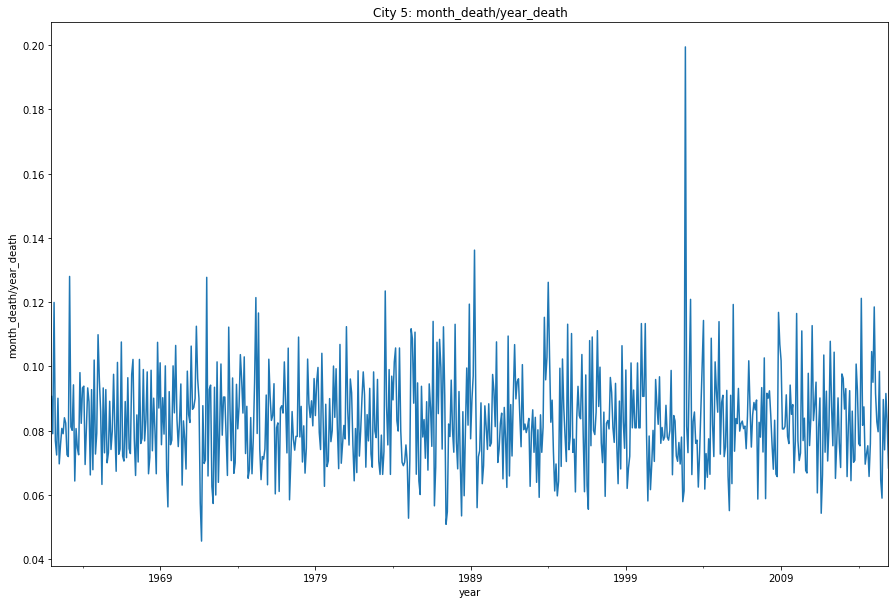

In [26]:
df_list_two[5]['month/year'].plot()
plt.title('City 5: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

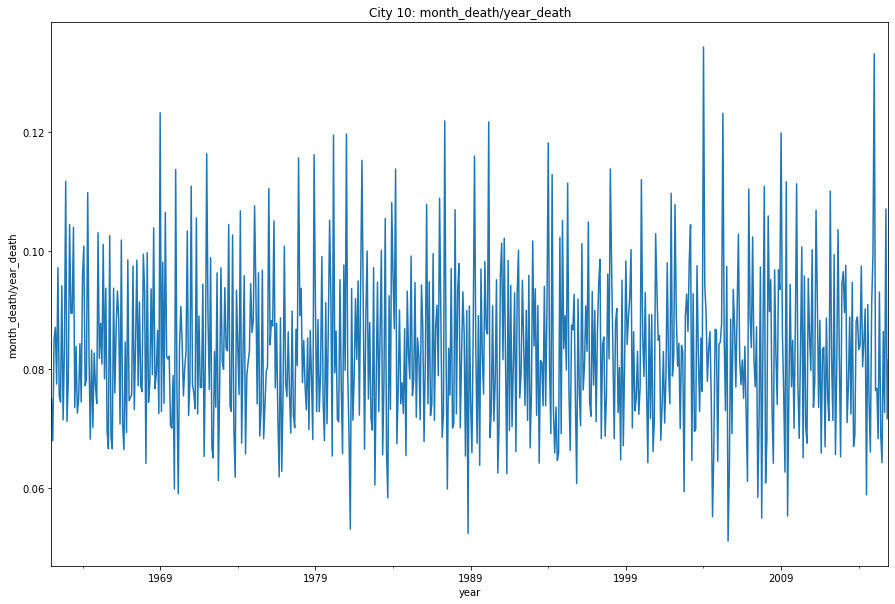

In [27]:
df_list_two[10]['month/year'].plot()
plt.title('City 10: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

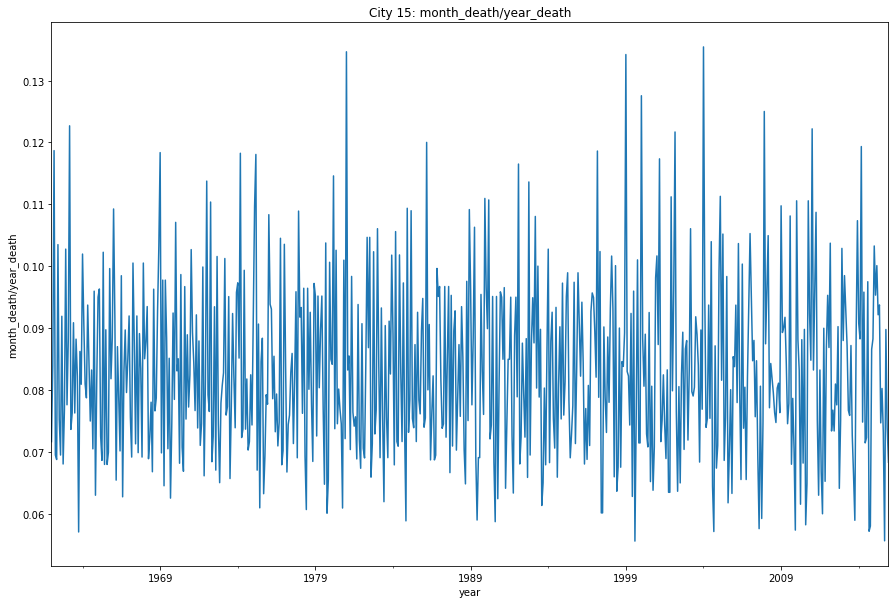

In [28]:
df_list_two[15]['month/year'].plot()
plt.title('City 15: month_death/year_death')
plt.xlabel('year')
plt.ylabel('month_death/year_death')
plt.show()

#### Outliers

As can be seen most clearly in the plot of 'City 5', outliers are present in the data.  Because this analysis is looking to model the normal or most common behavior of this phenomona, extream outliers should be eliminated.  We are already seeking to make predictions 5 years out from the data set, we do not want any recent extreme results to contaminate our results. 

We will replace outlier points with the mean of their respective cities

In [29]:
for X in df_list_two:
    x_bar=X['month/year'].mean()
    s=X['month/year'].std()
    upper_bound, lower_bound = x_bar + 3*s,x_bar - 3*s
    X.loc[X['month/year']>upper_bound,'month/year']= X['month/year'].mean()
    X.loc[X['month/year']<lower_bound,'month/year']= X['month/year'].mean()

#### Resampling

We are attempting to make predictions five years out from the data set. This means that if we use the monthly proportion of deaths, we will be forcasting 70 periods into the future.  This is unreasonable and boarderline impossible.  Since we are only interested in the proportion of total yearly deaths by month for the months of February through October, we will sum these months for each year, and drop all extranious information.  This will limit the size of our dataset, but is will allow us to make more reasonable predictions.  It is a worthy tradeoff.  

In [30]:
df_list_three=[]
for test in df_list_two:
    test['index']=test.index
    january=test['index'].astype(str).str.contains('-01-')
    november=test['index'].astype(str).str.contains('-11-')
    december=test['index'].astype(str).str.contains('-12-')
    test=pd.DataFrame(test.loc[~january & ~november & ~december])
    test=test.resample('A').sum()
    test=test[['month/year']]
    df_list_three.append(test)
df_list_two=df_list_three

Now to check that all cities data is over the same time interval

In [31]:
test=[1]
for i in range(1,len(df_list_two)):
    if set(df_list_two[0].index) == set(df_list_two[i].index):
        test.append(1)
    else:
        test.append(0)

In [32]:
np.sum(np.array(test))

93

In [33]:
len(test)

97

In [34]:
for i, j in enumerate(test,start=0):
    if j==0:
        print(i)

25
62
79
94


For different reasons, the cities that share these indexs have data that is incomplete.  It either begins after 1962, or terminates before 2015.  We will terminate the data sets for convenience.  

In [35]:
del df_list_two[94]
del df_list_two[79]
del df_list_two[62]
del df_list_two[25]

In [36]:
len(df_list_two)

93

We are now left with time series for 93 U.S. cities listing the total proportion of yearly deaths that ocuured within the months of February through October, from years 1962-2015.

## Modeling 

### AR Model

#### Test for Stationarity 

In [37]:
#This loop will notify when cities have a p-value greater than .001:
from statsmodels.tsa.stattools import adfuller
p_value_list=[]
for i in range(len(df_list_two)):
    X = df_list_two[i]['month/year'].values
    result = adfuller(X)
    if result[1] > .001:
        p_value_list.append((int(i),result[1]))
print(p_value_list)     

[(13, 0.32859214869346515), (14, 0.3112564123674604), (18, 0.3855271966478052), (19, 0.09457758552530615), (51, 0.007054345668658072), (58, 0.03769864033189768), (67, 0.0012418925370639292), (70, 0.3718478795004497), (73, 0.46970702055603786)]


For convenience we will delete all time series from cities that are non-stationary

In [38]:
indecies=[]
for item in p_value_list:
    indecies.append(item[0])
for index in sorted(indecies, reverse=True):
    del df_list_two[index]

And now for the modeling.  We only investigate AR(1) through AR(6) because past that we start to see convergance issues for some of the datasets.

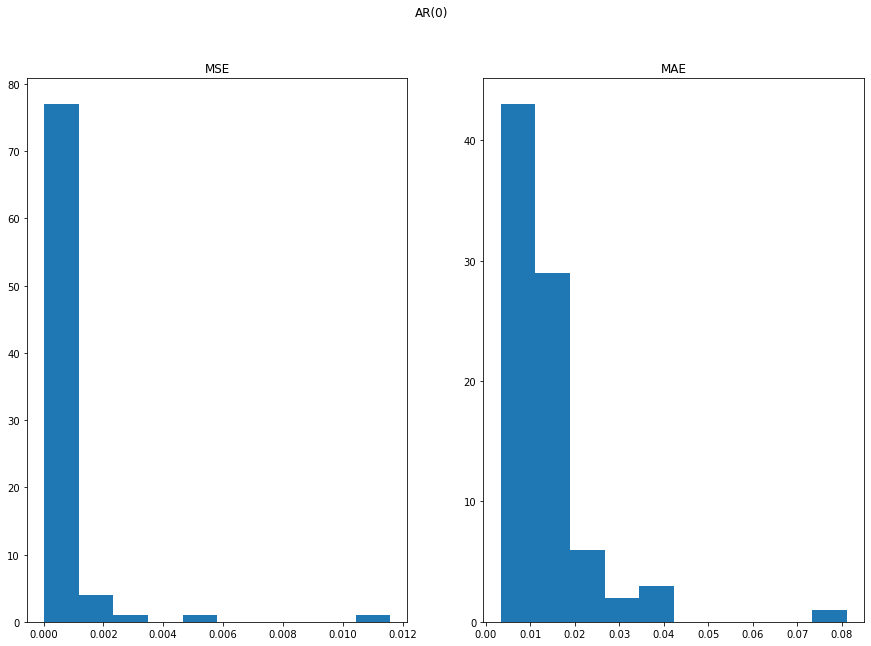

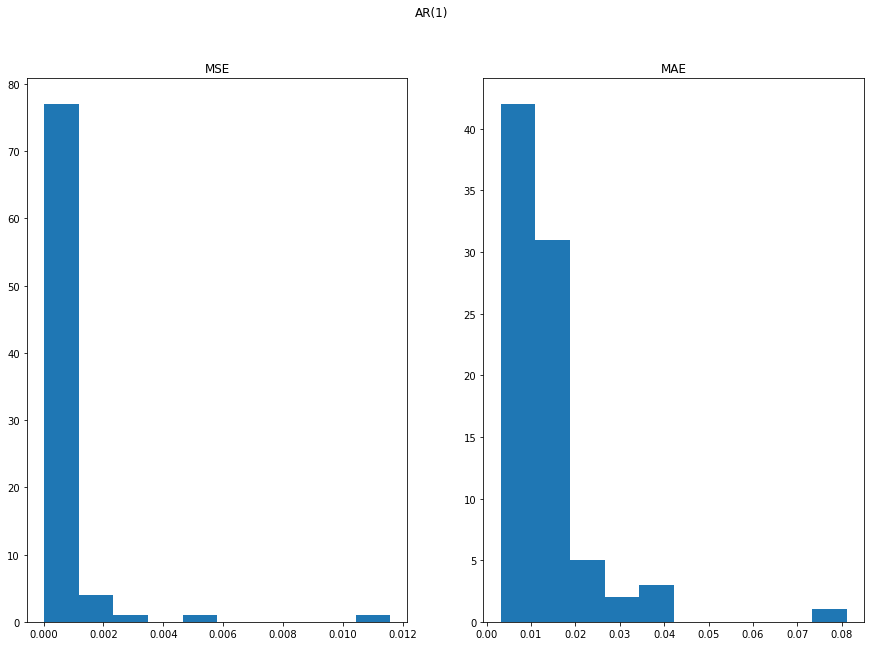

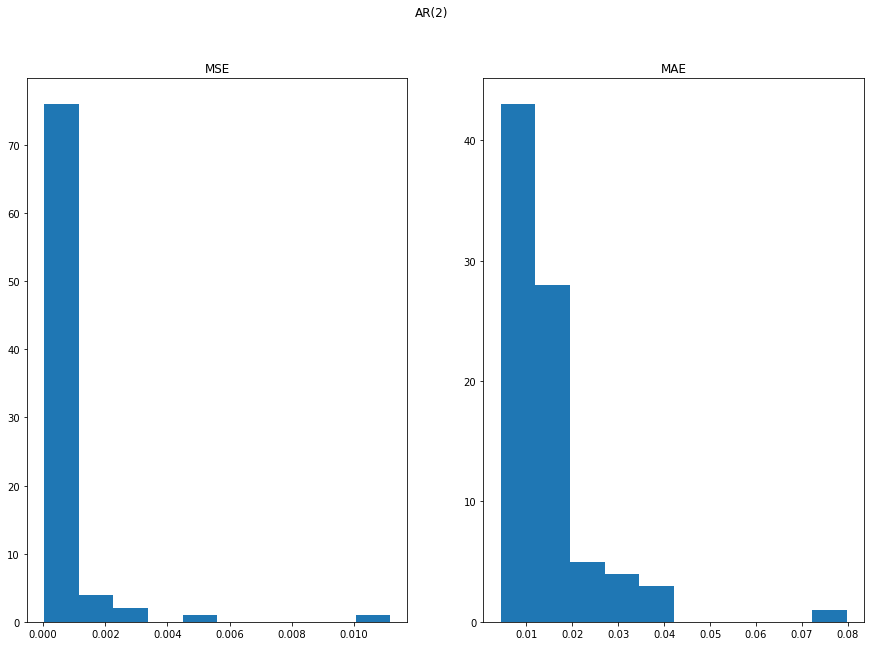

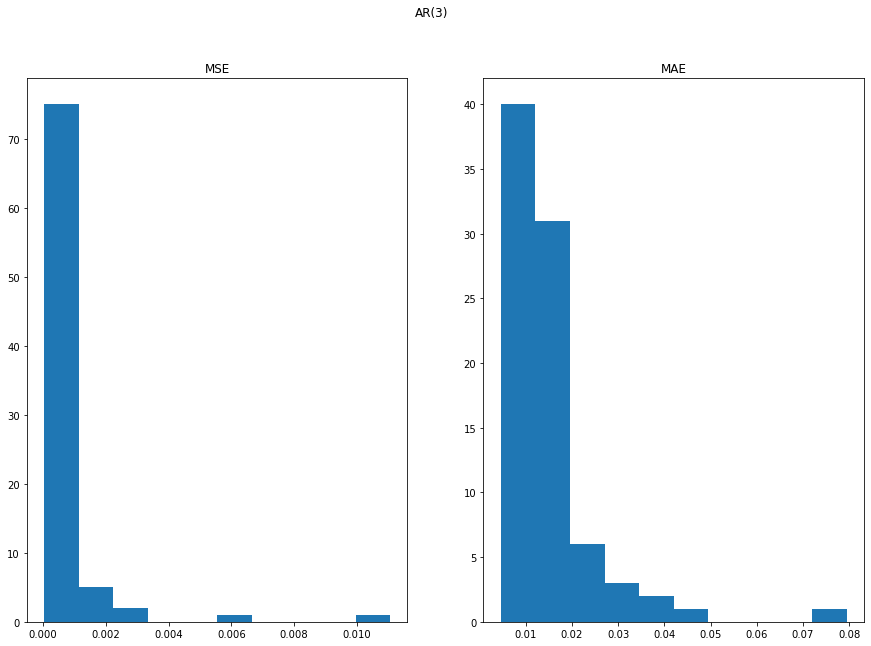

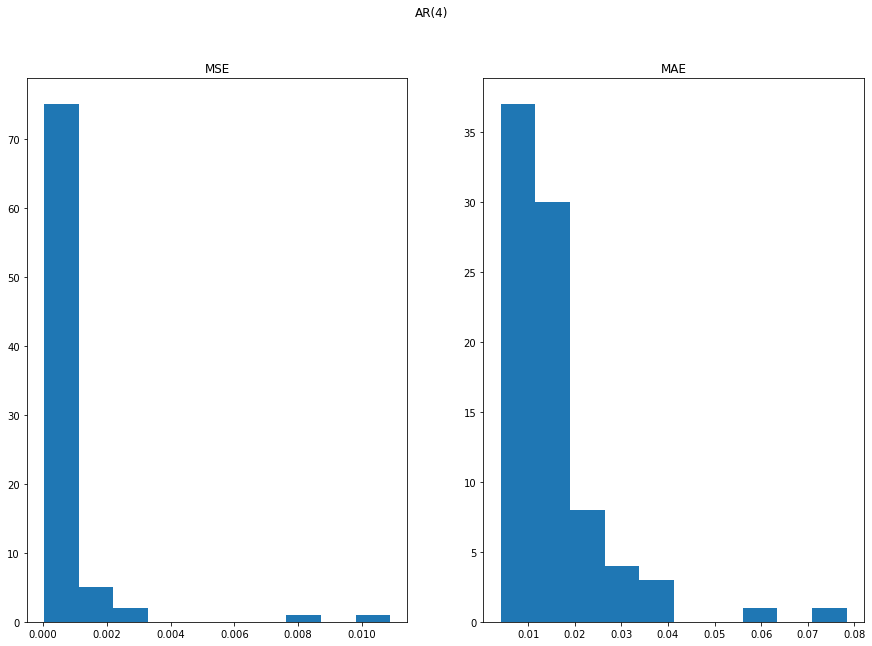

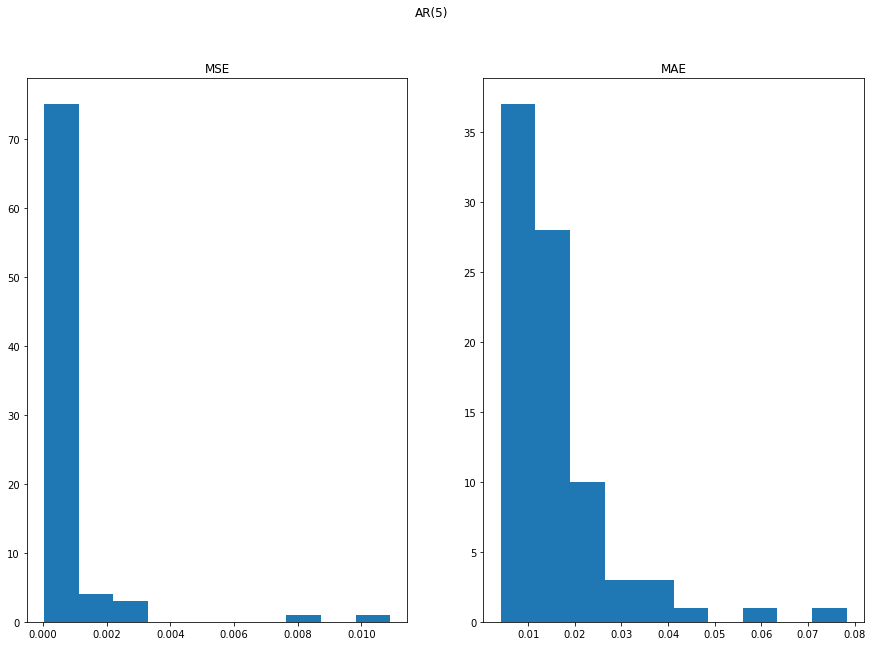

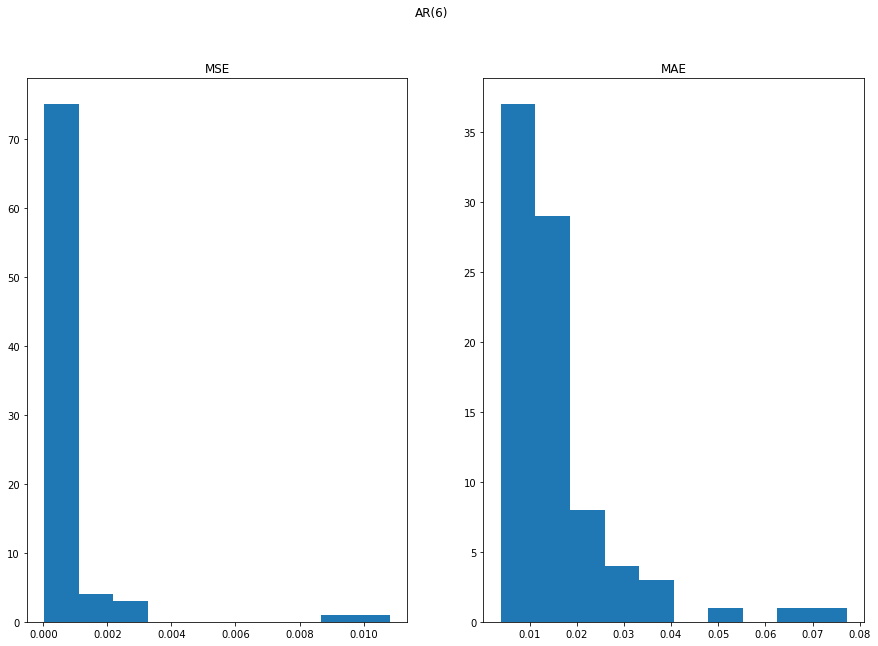

([0.04383531313198729,
  0.04352751597485173,
  0.045688052025305285,
  0.04749070258220321,
  0.050459637967265575,
  0.05255707440884098,
  0.05263284149515148],
 [1.1788823872584404,
  1.1730046565916579,
  1.2187016790878034,
  1.2444836007832916,
  1.274388021059818,
  1.3018140153137032,
  1.2930328612284083])

In [39]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

def AR(df_list,plots=False):
    """This fuction loops through a list of DataFrames and applys"""
    """AR models to the entire list, prints histograms of the MSE/MAE"""
    """Distributions to check for outliers, and sums MSE/MAE across"""
    """all datasets for each AR model"""
    MSE_List_AR=[]
    MAE_List_AR=[]
    for i in range(0,7):
        mse_list=[]
        mae_list=[]
        for df in df_list:
            X = df['month/year'].values
            train, test = X[:(len(X)-5)], X[(len(X)-5):]
            model = ARIMA(train, order=(i,0,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast(steps=len(test))
            MSE=mean_squared_error(test,output[0])
            MAE=mean_absolute_error(test,output[0])
            mse_list.append(MSE)
            mae_list.append(MAE)
        if plots==True:
            fig, (ax1,ax2) = plt.subplots(1,2)
            fig.suptitle('AR('+str(i)+')')
            ax1.hist(mse_list)
            ax1.set_title('MSE')
            ax2.hist(mae_list)
            ax2.set_title('MAE')
            plt.show()
        mse_sum=np.sum(np.array(mse_list))
        mae_sum=np.sum(np.array(mae_list))
        MSE_List_AR.append(mse_sum)
        MAE_List_AR.append(mae_sum)
    return MSE_List_AR, MAE_List_AR

AR(df_list_two,plots=True)

After inspecting the charts above, we can see that some datasets contribute up to 8 times more than othersto the summed MSE.  Let us delete the datasets that contribute the most error, and try again.  

In [40]:
#AR(5) had the most combined error, so we will try to use that as a baseline
mae_list=[]
for df in df_list_two:
    X = df['month/year'].values
    train, test = X[:(len(X)-5)], X[(len(X)-5):]
    model = ARIMA(train, order=(5,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=len(test))
    MAE=mean_absolute_error(test,output[0])
    mae_list.append(MAE)

In [41]:
indecies=[]
for i, j in enumerate(list(np.array(mae_list)<.02),start=0):
    if j==False:
        indecies.append(i)        
for index in indecies[::-1]:
    del df_list_two[index]

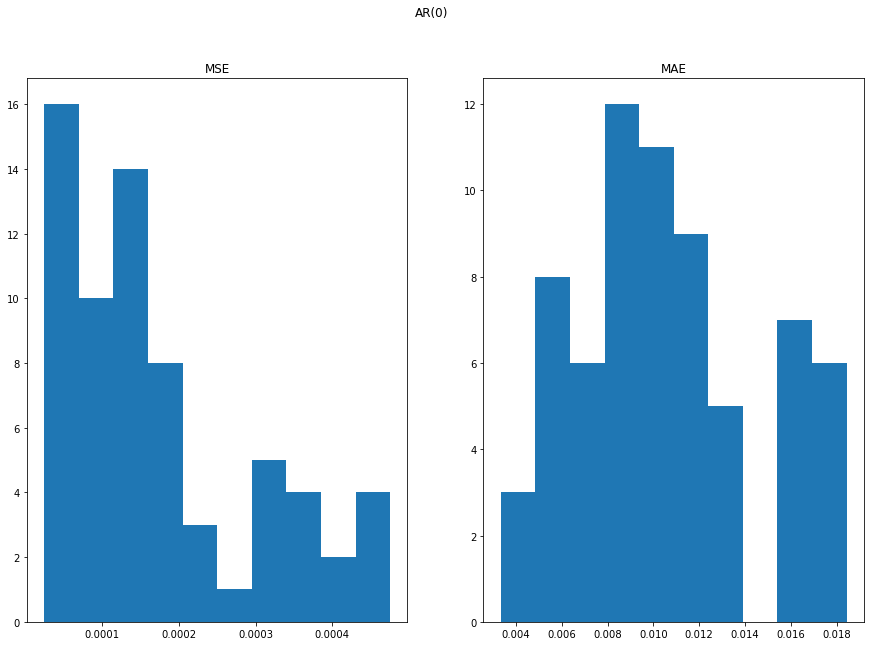

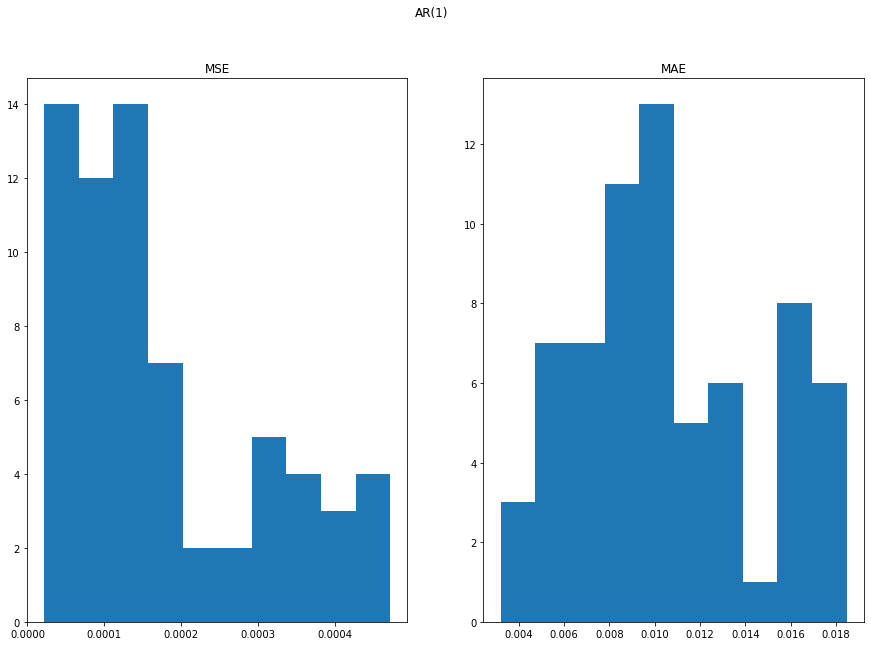

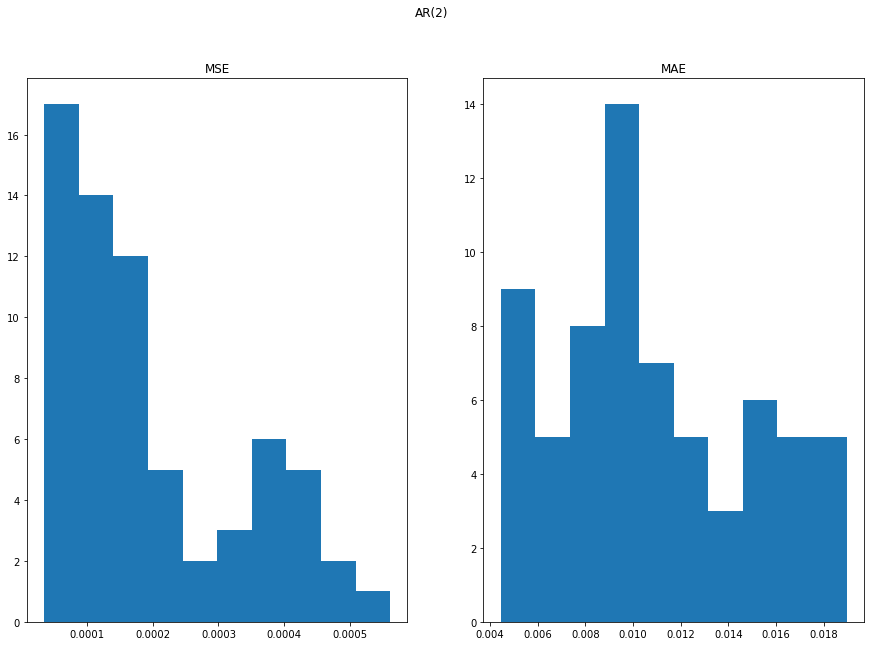

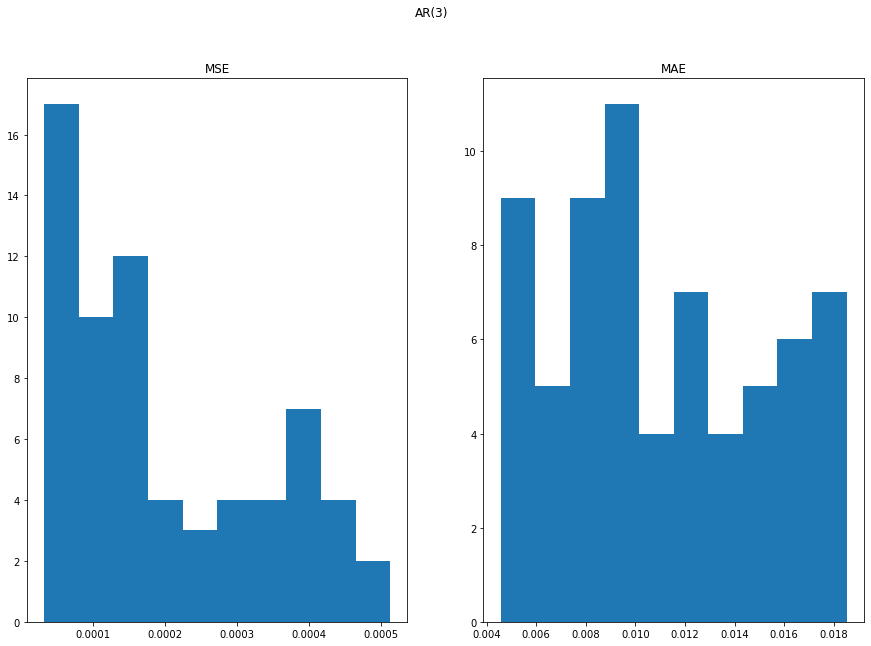

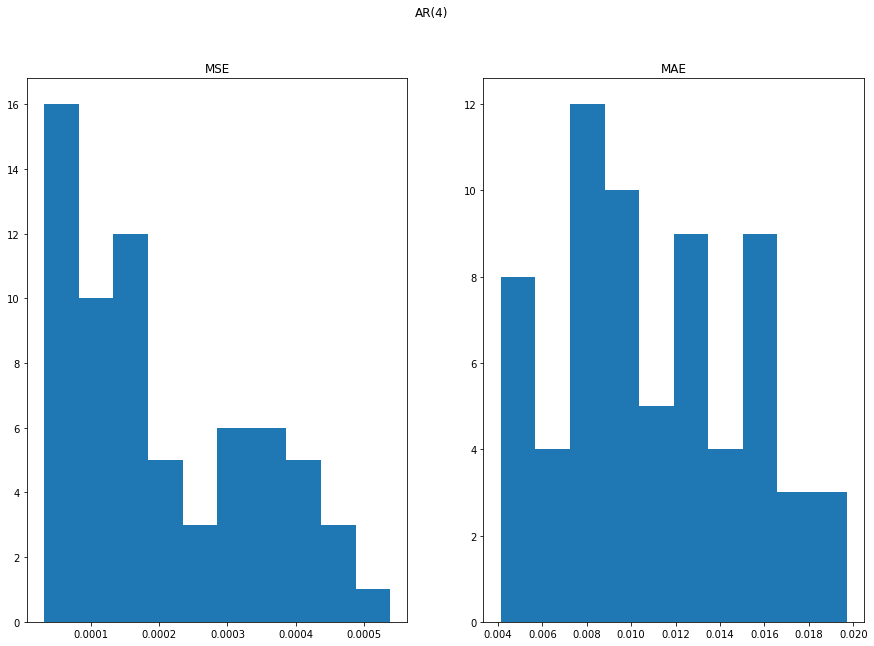

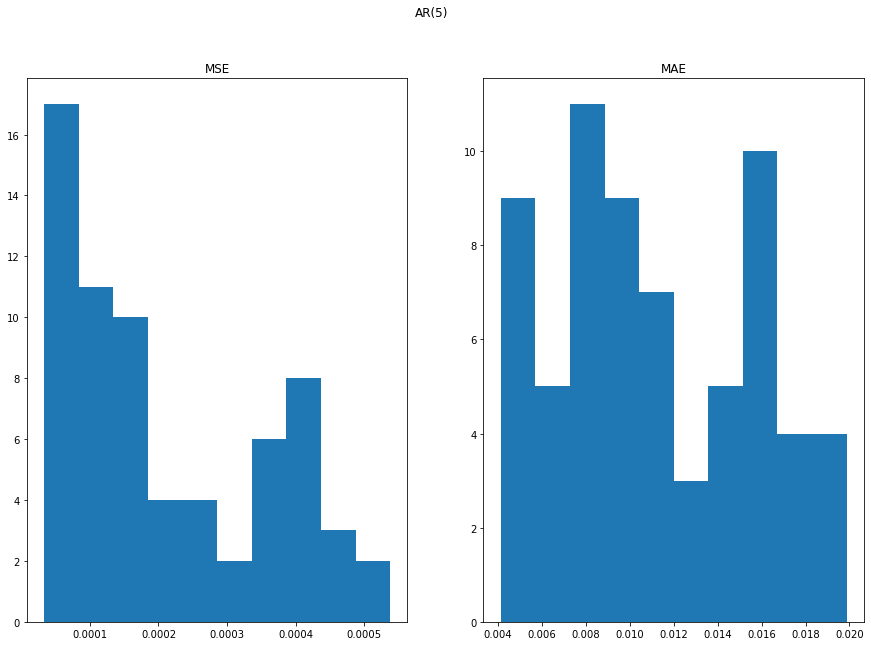

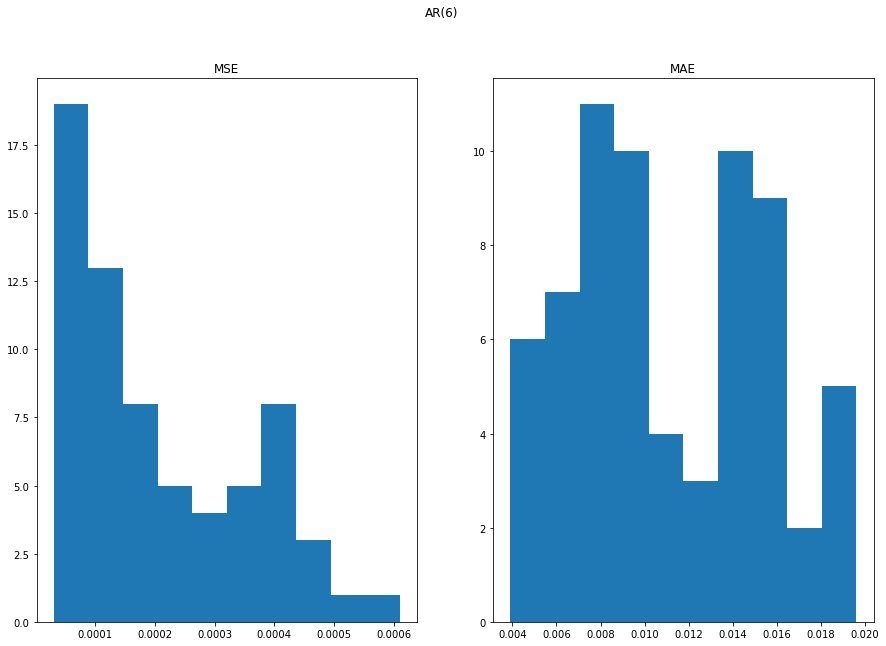

([0.011788975424504447,
  0.011940841898324003,
  0.012788430721687182,
  0.013354677194009207,
  0.01341704035354423,
  0.014013600350013453,
  0.01387386248067931],
 [0.7007717383970837,
  0.7043878718156467,
  0.7252401459435273,
  0.7373470900157743,
  0.7399613891336282,
  0.7508734983032012,
  0.741943151787984])

In [42]:
AR(df_list_two,plots=True)

Thats much better.  It appears that an AR(0) model, i.e. the average, is the best estimator. MSE AR(0)= 0.011788975424504447 and MAE AR(0)= 0.7007717383970837

### Facebooks Prophet

In [43]:
def facebook(df_list):
    """This fuction takes a list of dataframes and runs facebooks prophet on each one, and provides a list of"""
    """MSE and MAE"""
    from fbprophet import Prophet
    MSE_List_FB=[]
    MAE_List_FB=[]
    for test in df_list:
        X=test.loc['2011':'2015']['month/year'].values
        test=pd.DataFrame(test.loc[:'2010']).reset_index()
        test.columns=['ds','y']
        test['ds']=pd.to_datetime(test['ds'])
        model = Prophet()
        model.fit(test)
        future = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31']
        future = pd.DataFrame(future)
        future.columns = ['ds']
        future['ds']= pd.to_datetime(future['ds'])
        forecast = model.predict(future)
        yhat=forecast.yhat.values
        MSE=mean_squared_error(X,yhat)
        MAE=mean_absolute_error(X,yhat)
        MSE_List_FB.append(MSE)
        MAE_List_FB.append(MAE)
    return MSE_List_FB, MAE_List_FB

MSE_List_FB, MAE_List_FB = facebook(df_list_two)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

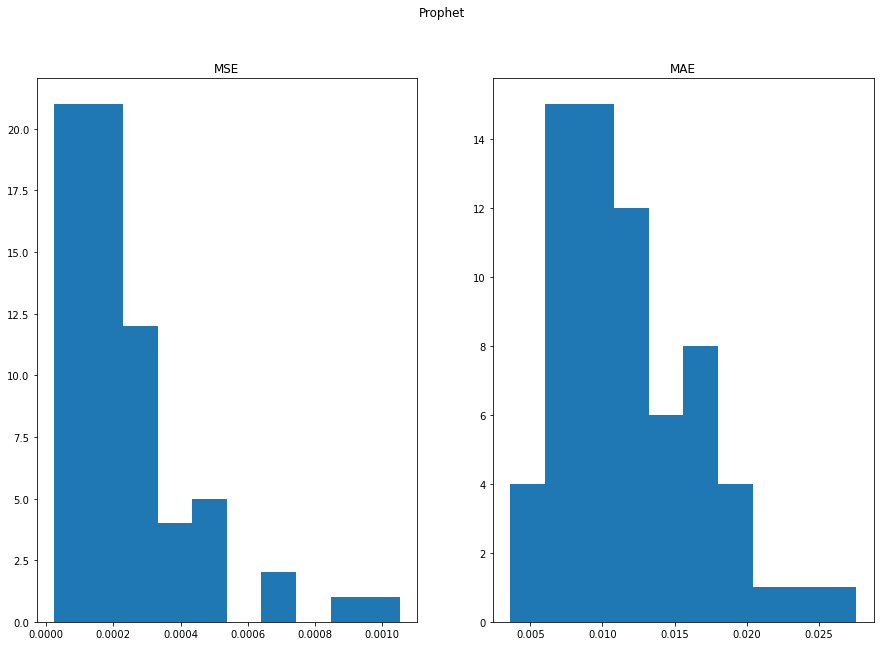

In [44]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Prophet')
ax1.hist(MSE_List_FB)
ax1.set_title('MSE')
ax2.hist(MAE_List_FB)
ax2.set_title('MAE')
plt.show()

There is no reason to expect that making any further deletions will have any affect on the model performance

In [45]:
np.sum(np.array(MSE_List_FB)),np.sum(np.array(MAE_List_FB))

(0.015571049865367876, 0.7874998580908816)

It seems that our models do not have more predictive power than the average.  Sometimes the simplest model is the best model.  We will look at the distribution of the averages for all time series.  

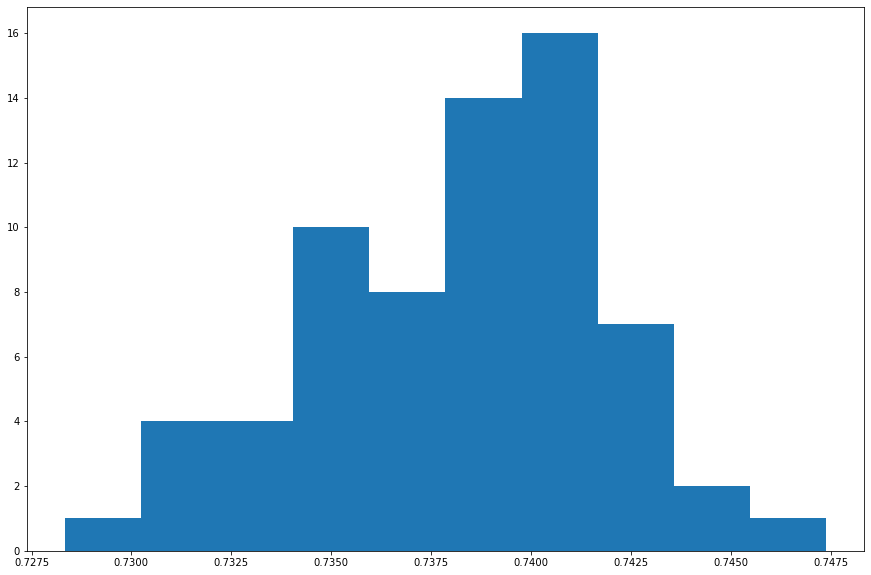

In [46]:
average_list=[]
for df in df_list_two:
    average=df['month/year'].mean()
    average_list.append(average)
plt.hist(average_list)
plt.show()

Lets bootstrap a confidence interval from the list of averages

In [47]:
from random import sample
average_list_bootstrap=[]
for i in range(10000):
    x=sample(average_list,len(average_list))
    average_list_bootstrap.append(x)

In [48]:
mean_death=np.percentile(np.array(average_list_bootstrap),50)
lower_99_death=np.percentile(np.array(average_list_bootstrap),1)
upper_99_death=np.percentile(np.array(average_list_bootstrap),99)

In [50]:
print('Expected Proportion of Yearly Deaths from February Through October 2020: '+str(mean_death))
print('Bootstrapped 99% CI: '+str((lower_99_death,upper_99_death)))

Expected Proportion of Yearly Deaths from February Through October 2020: 0.7385857521407692
Bootstrapped 99% CI: (0.7283371932078238, 0.7473804733149562)
